In [184]:
import numpy as np
import matplotlib.pyplot as plt

# 定义模型（三层神经网络分类器）

In [185]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes                # 自定义隐藏层大小
        self.output_size = output_size
        self.activation = activation
        self.weights = []
        self.biases = []
        self.learning_rate = None
        self.reg_lambda = None
        
        # 初始化每个层的权重w和偏差b
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]))
            self.biases.append(np.random.randn(layer_sizes[i]))

    # 定义激活函数类型
    def _activation_function(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Activation function '{}' not supported".format(self.activation))
    
    # softmax
    def _softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # 前向传播
    def forward(self, X):
        self.layer_outputs = []
        input_data = X
        for i in range(len(self.weights)):
            layer_input = np.dot(input_data, self.weights[i]) + self.biases[i]
            if i == len(self.weights) - 1:
                layer_output = self._softmax(layer_input)          # 输出层的激活函数-softmax
            else:
                layer_output = self._activation_function(layer_input)
            self.layer_outputs.append(layer_output)
            input_data = layer_output
        return input_data
    
    # 反向传播
    def backward(self, X, y, learning_rate, reg_lambda):
        num_examples = X.shape[0]
        # 从输出层的误差开始
        delta = self.layer_outputs[-1] - y      # 输出层误差
        dweights = []
        dbiases = []
    
        for i in reversed(range(len(self.weights))):
            # 计算权重和偏差的梯度
            if i == 0:         # 输入：X
                dW = np.dot(X.T, delta)
            else:              # 输入：前一层的输出
                dW = np.dot(self.layer_outputs[i-1].T, delta)
        
            dB = np.sum(delta, axis=0)
        
            # 存储梯度
            dweights.insert(0, dW)
            dbiases.insert(0, dB)
        
            if i > 0:
                # 计算上一层的delta
                if self.activation == 'relu':
                    delta = np.dot(delta, self.weights[i].T) * (self.layer_outputs[i-1] > 0)
                elif self.activation == 'sigmoid':
                    output = self.layer_outputs[i-1]
                    delta = np.dot(delta, self.weights[i].T) * output * (1 - output)
                elif self.activation == 'tanh':
                    output = self.layer_outputs[i-1]
                    delta = np.dot(delta, self.weights[i].T) * (1 - np.power(output, 2))

        # 使用梯度更新权重和偏差
        for i in range(len(self.weights)):
            # 添加正则化项
            self.weights[i] -= learning_rate * (dweights[i] / num_examples + reg_lambda * self.weights[i])
            self.biases[i] -= learning_rate * dbiases[i] / num_examples

# 训练

## 交叉熵损失函数

In [186]:
def softmax_loss(predictions, targets):
    # 用于计算交叉熵损失的安全对数计算
    log_predictions = np.log(predictions + 1e-7)  # 添加一个小的值以避免对0取对数
    # 计算每个样本的交叉熵损失
    cross_entropy_loss = -np.sum(targets * log_predictions, axis=1)
    # 求平均损失
    data_loss = np.mean(cross_entropy_loss)
    return data_loss

## 正确率计算

In [187]:
def compute_accuracy(predictions, targets):
    targets = np.argmax(targets, axis=1)                    # 将one-hot编码转为整数索引
    predictions = np.argmax(predictions, axis=1)                
    return np.mean(predictions == targets)

## 学习率下降

In [188]:
def learning_rate_decay(initial_lr, epoch, decay_rate):
    return initial_lr / (1 + decay_rate * epoch)

## 训练模型

In [190]:
def train(X_train, y_train, X_val, y_val, model, initial_learning_rate=0.01, reg_lambda=0.01, num_epochs=100, batch_size=64, decay_rate=0.01, verbose=True):
    best_val_accuracy = 0.0
    best_weights = None
    train_loss_history = []
    val_loss_history = []  # 添加验证集上的loss记录
    val_accuracy_history = []

    for epoch in range(num_epochs):
        shuffle_index = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[shuffle_index]
        y_train_shuffled = y_train[shuffle_index]
        
        # 学习率衰减
        learning_rate = learning_rate_decay(initial_learning_rate, epoch, decay_rate)
        
        # 小批量训练(SGD优化器)
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            
            # 前向传播
            predictions = model.forward(X_batch)
            loss = softmax_loss(predictions, y_batch)
            # 添加L2正则化项
            for weights in model.weights:
                loss += 0.5 * reg_lambda * np.sum(weights ** 2)
            
            # 反向传播
            model.backward(X_batch, y_batch, learning_rate, reg_lambda)
        
        # 计算在验证集上的损失和准确率
        val_predictions = model.forward(X_val)
        val_loss = softmax_loss(val_predictions, y_val)  # 计算验证集上的损失
        val_accuracy = compute_accuracy(val_predictions, y_val)
        
        # 存储最佳的模型权重
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_weights = [np.copy(w) for w in model.weights]
        
        # 记录 loss 和 accuracy 
        train_loss_history.append(loss)
        val_loss_history.append(val_loss)  # 记录验证集上的loss
        val_accuracy_history.append(val_accuracy)
        
        if verbose:
            print("Epoch {}, Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(epoch+1, loss, val_loss, val_accuracy * 100))
    
    # 自动保存最优的模型权重
    if best_weights is not None:
        model.weights = best_weights
    
    # 绘制训练集上的loss曲线
    plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()
    
    # 绘制验证集上的loss曲线
    plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()
    
    # 绘制验证集上的accuracy曲线
    plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

# 测试模型

In [191]:
def test(X_test, y_test, model):
    test_predictions = model.forward(X_test)
    test_accuracy = compute_accuracy(test_predictions, y_test)
    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# 参数查找

In [193]:
def parameter_search(X_train, y_train, X_val, y_val, input_size, output_size, hidden_sizes, activation_functions, 
                     learning_rates, reg_lambda_values, decay_rates, num_epochs=100, batch_size=64):
    best_model = None
    best_val_accuracy = 0.0
    best_decay_rate = None
    
    for hidden_size in hidden_sizes:                          # 隐藏层尺寸
        for activation in activation_functions:               # 激活函数
            for learning_rate in learning_rates:              # 学习率
                for reg_lambda in reg_lambda_values:          # 正则化参数
                    for decay_rate in decay_rates:            # 学习率衰减速率
                        # 构建神经网络模型
                        model = NeuralNetwork(input_size, hidden_size, output_size, activation)
                        model.learning_rate = learning_rate
                        model.reg_lambda = reg_lambda
                        # 训练模型，传入学习率衰减速率
                        train(X_train, y_train, X_val, y_val, model, learning_rate, reg_lambda, num_epochs, batch_size, decay_rate, verbose=False)
                        # 在验证集上评估性能
                        val_predictions = model.forward(X_val)
                        val_accuracy = compute_accuracy(val_predictions, y_val)
                        
                        if val_accuracy > best_val_accuracy:
                            best_val_accuracy = val_accuracy
                            best_model = model
                            best_decay_rate = decay_rate
                            
                        print("Hidden Size: {}, Activation: {}, Learning Rate: {}, Regularization Lambda: {}, Decay Rate: {}, Validation Accuracy: {:.2f}%"
                              .format(hidden_size, activation, learning_rate, reg_lambda, decay_rate, val_accuracy * 100))
    
    # 输出最佳模型的参数
    print("\nBest Model Parameters:")
    print("Hidden Sizes:", best_model.hidden_sizes)
    print("Activation Function:", best_model.activation)
    print("Learning Rate:", best_model.learning_rate)
    print("Regularization Lambda:", best_model.reg_lambda)
    print("Best Decay Rate:", best_decay_rate)
    
    return best_model

# 数据预处理

## 加载数据集

In [194]:
import os

def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
    data = data[16:].reshape(-1, 28, 28)  # 将数据reshape为28x28的图片，并去除头部的16字节
    return data.astype(np.float32) / 255.0  # 将像素值缩放到[0, 1]范围内

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
    data = data[8:]  # 去除头部的8字节
    return data.astype(np.int32)

In [195]:
# 数据集所在的文件夹路径
data_folder = 'data'

# 加载训练集图像和标签
train_images = load_mnist_images(os.path.join(data_folder, 'train-images-idx3-ubyte'))
train_labels = load_mnist_labels(os.path.join(data_folder, 'train-labels-idx1-ubyte'))

# 加载测试集图像和标签
test_images = load_mnist_images(os.path.join(data_folder, 't10k-images-idx3-ubyte'))
test_labels = load_mnist_labels(os.path.join(data_folder, 't10k-labels-idx1-ubyte'))

print("训练集图片数量:", train_images.shape[0])
print("训练集标签数量:", train_labels.shape[0])
print("测试集图片数量:", test_images.shape[0])
print("测试集标签数量:", test_labels.shape[0])

训练集图片数量: 60000
训练集标签数量: 60000
测试集图片数量: 10000
测试集标签数量: 10000


### 将图像扁平化为一维数组

In [196]:
# train_images 和 test_images 原始形状是 [num_samples, 28, 28]
# 将每个图像从28x28扁平化为长度784的一维数组
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [197]:
print("训练集形状:", train_images.shape)  # 应该显示 (num_samples, 784)
print("测试集形状:", test_images.shape)  # 应该显示 (num_samples, 784)

训练集形状: (60000, 784)
测试集形状: (10000, 784)


### 对图像标签进行one-hot编码

In [198]:
def one_hot_encode(labels, num_classes):
    # 创建一个形状为 (len(labels), num_classes) 的零矩阵
    one_hot = np.zeros((len(labels), num_classes))
    # 设置相应的索引为1
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

# 对训练和测试标签进行one-hot编码
train_labels_one_hot = one_hot_encode(train_labels, 10)
test_labels_one_hot = one_hot_encode(test_labels, 10)

### 划分训练集和验证集

In [199]:
from sklearn.model_selection import train_test_split

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

# 通过参数查找训练最佳模型

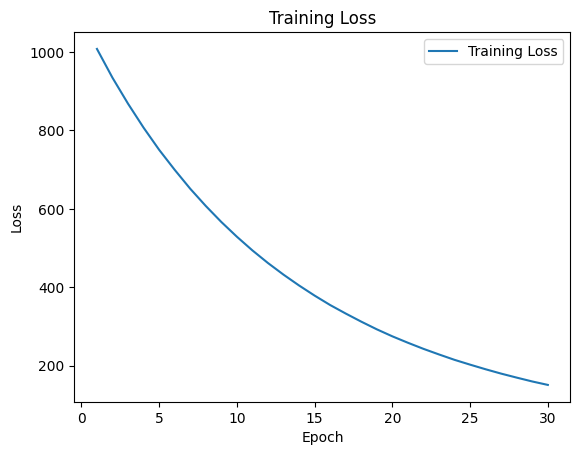

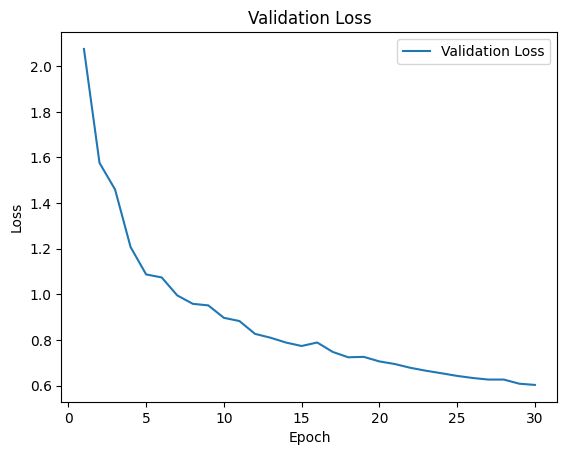

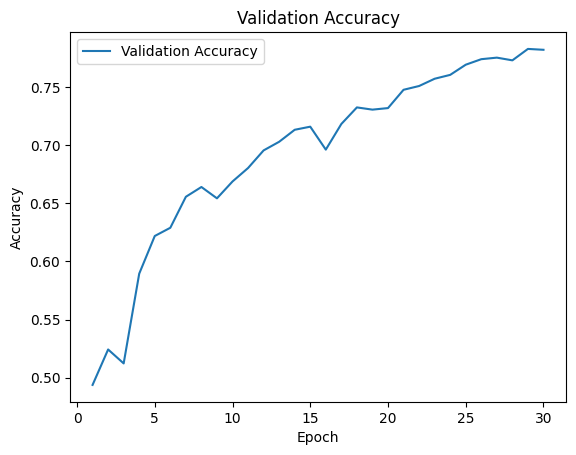

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.01, Decay Rate: 0.01, Validation Accuracy: 78.33%


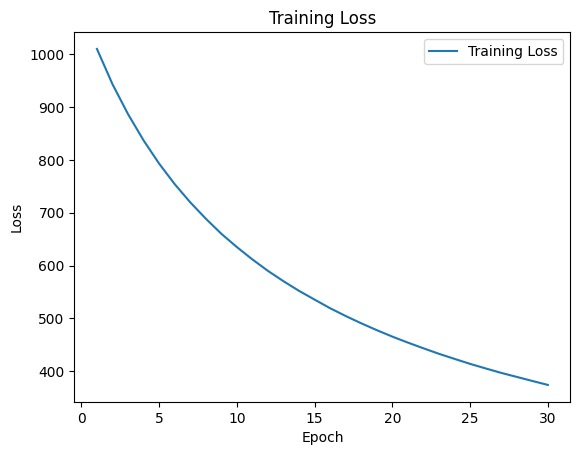

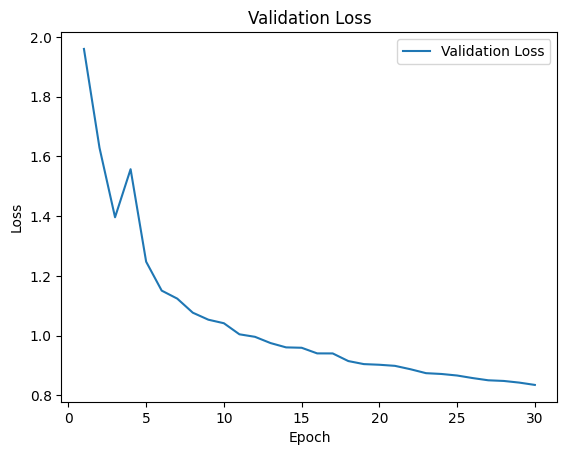

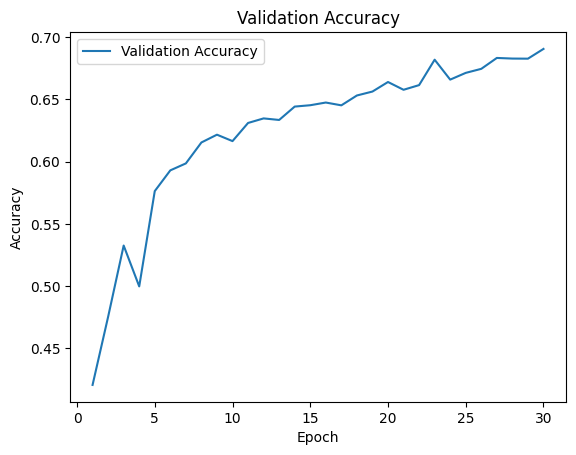

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.01, Decay Rate: 0.1, Validation Accuracy: 69.06%


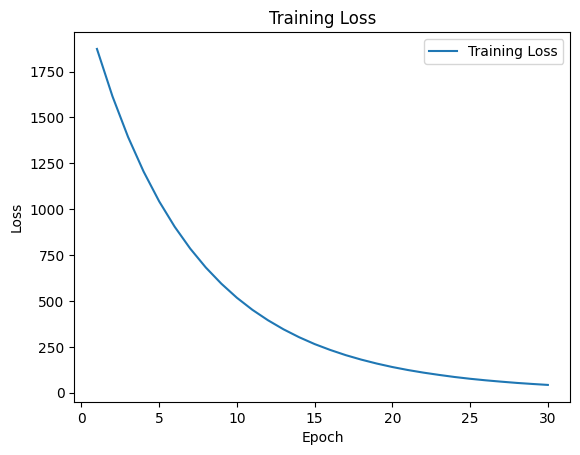

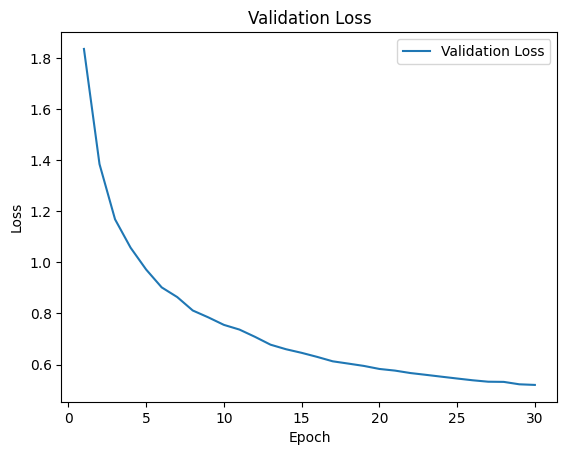

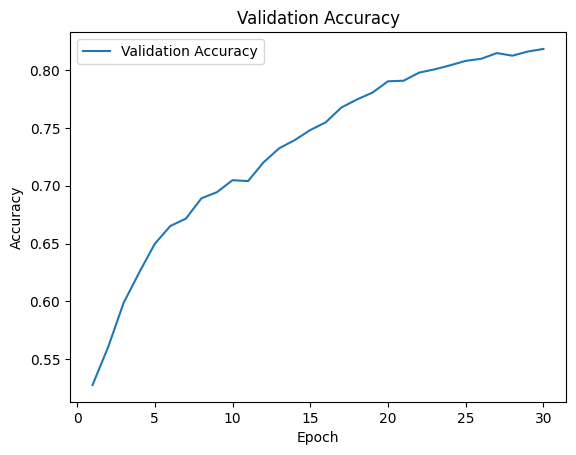

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.02, Decay Rate: 0.01, Validation Accuracy: 81.83%


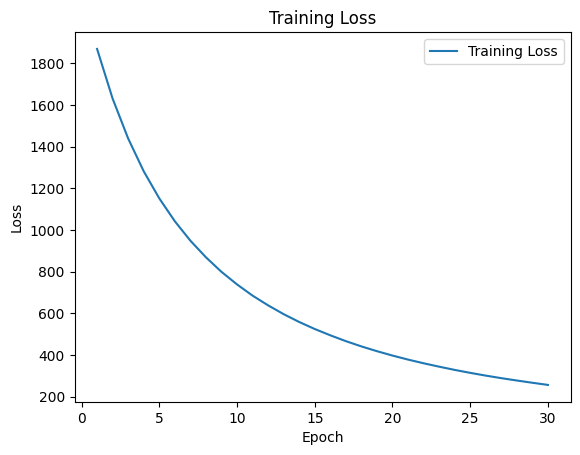

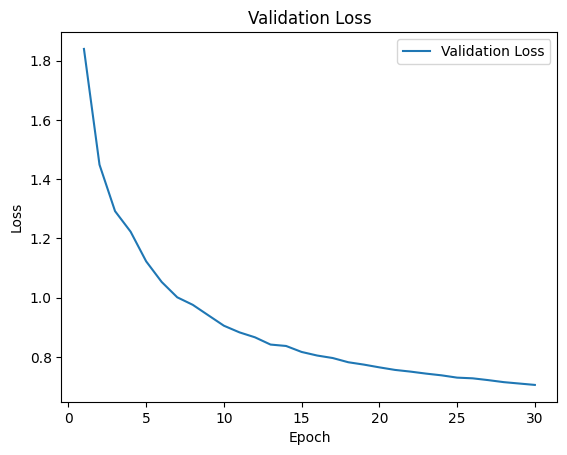

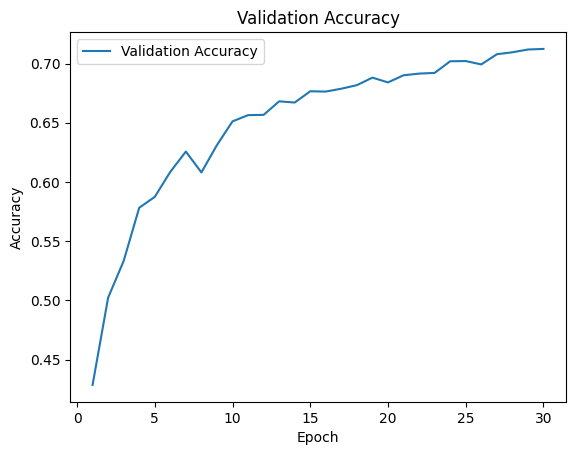

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.02, Decay Rate: 0.1, Validation Accuracy: 71.23%


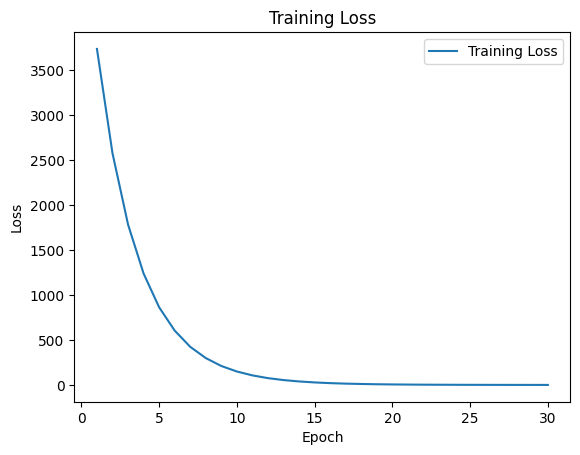

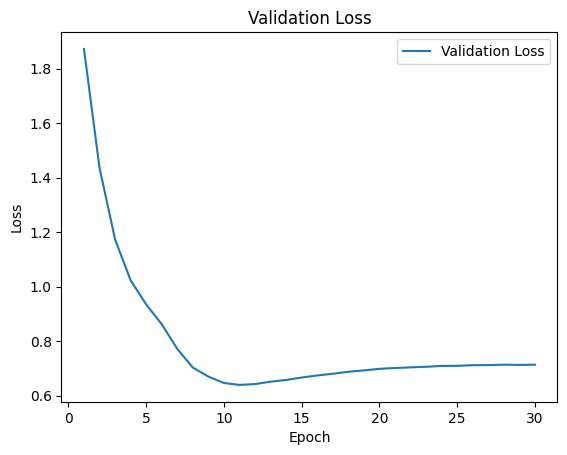

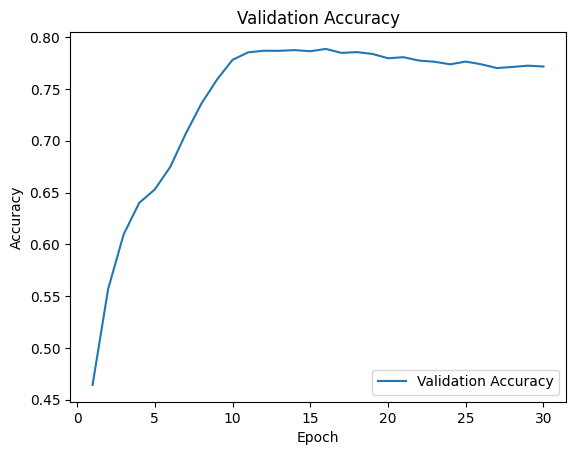

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.05, Decay Rate: 0.01, Validation Accuracy: 78.81%


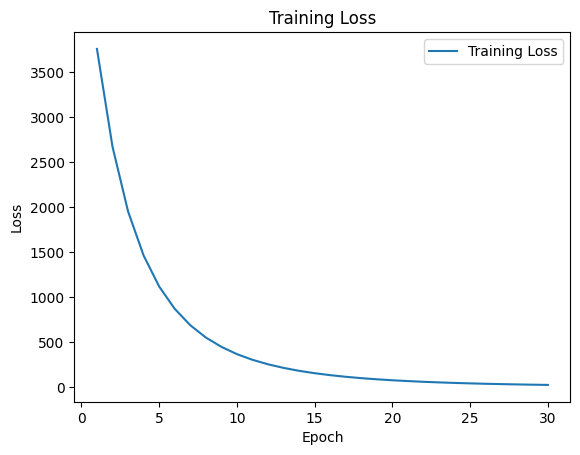

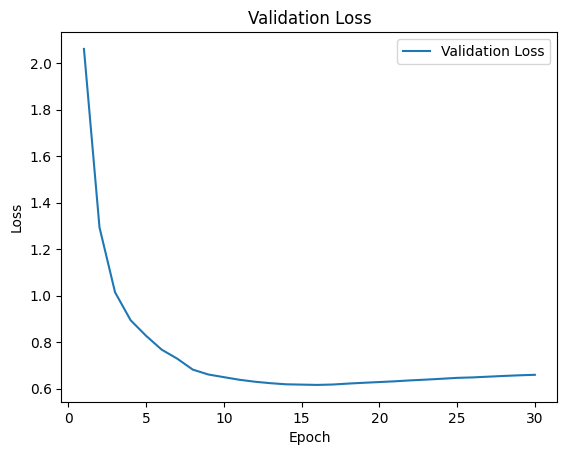

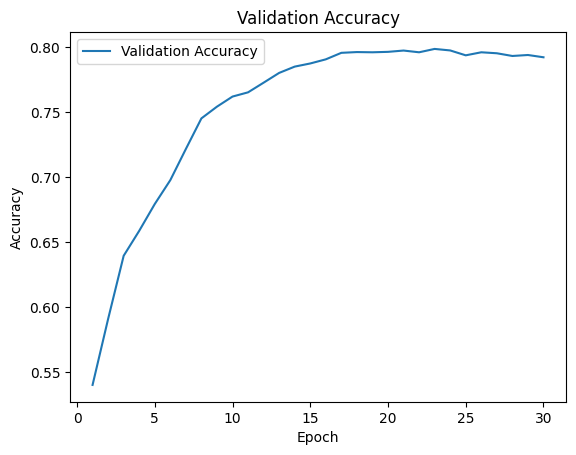

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.05, Decay Rate: 0.1, Validation Accuracy: 79.90%


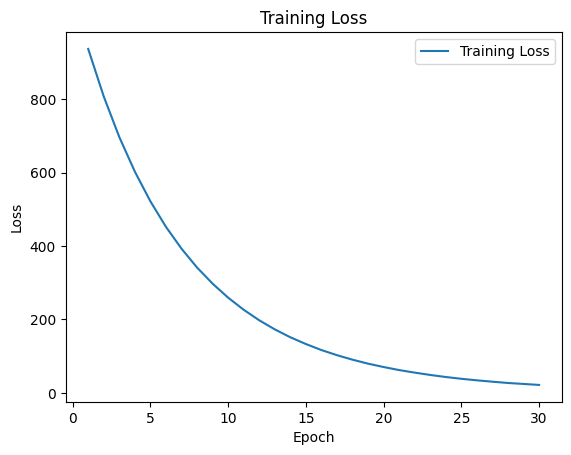

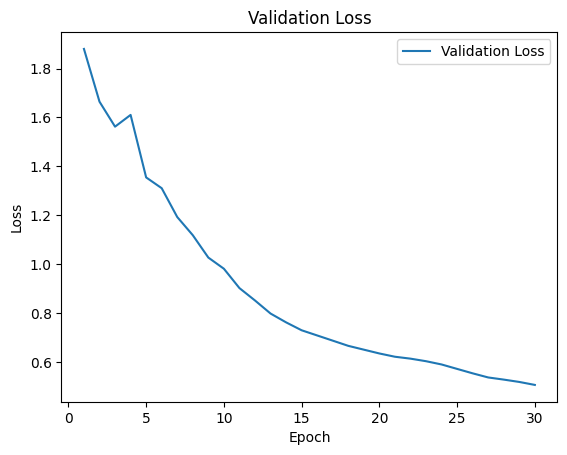

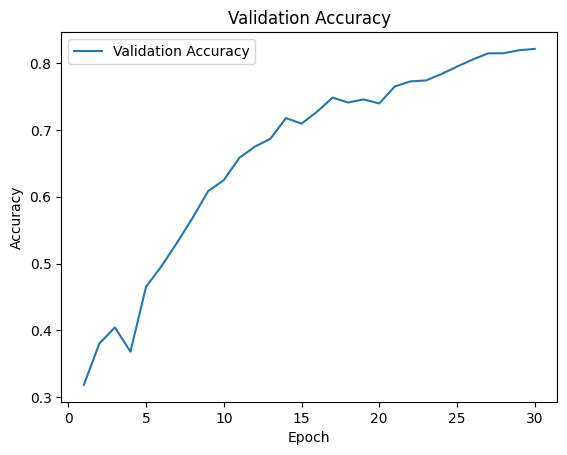

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.01, Decay Rate: 0.01, Validation Accuracy: 82.15%


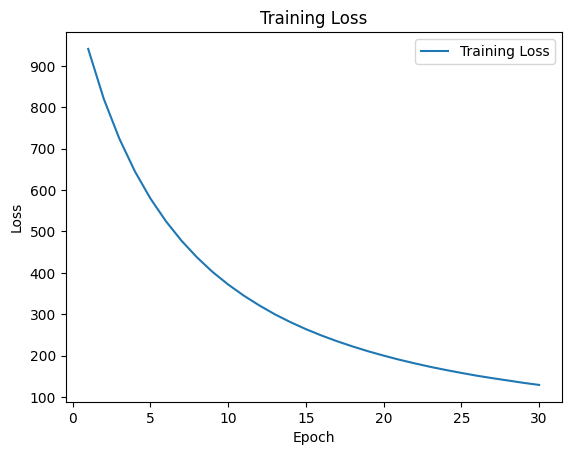

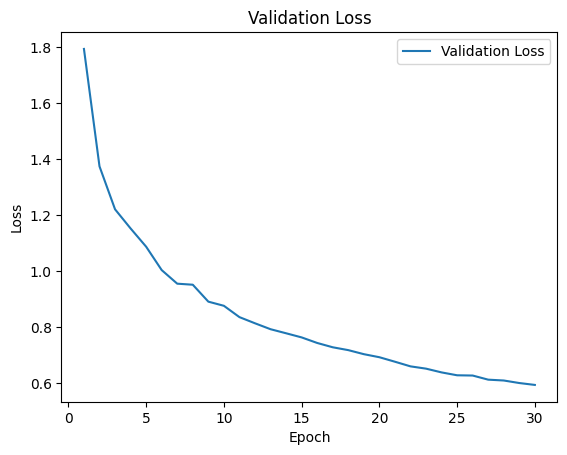

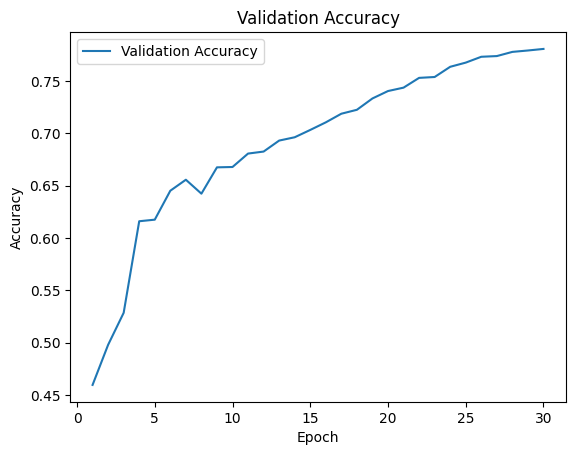

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.01, Decay Rate: 0.1, Validation Accuracy: 78.06%


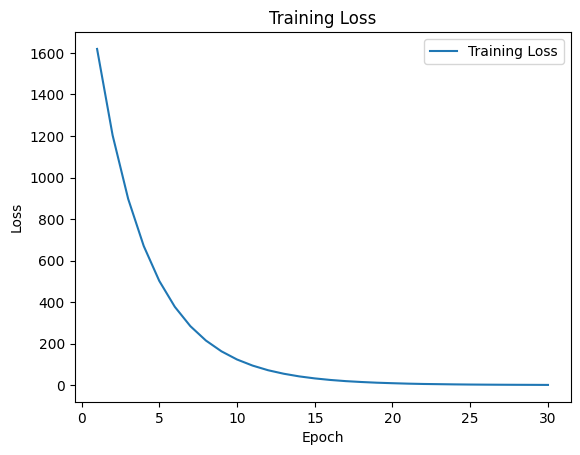

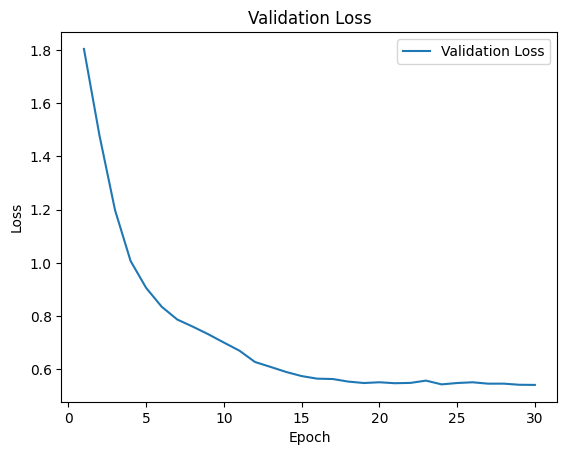

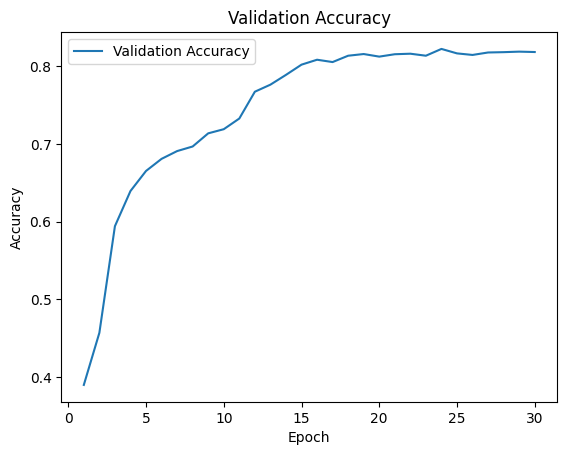

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.02, Decay Rate: 0.01, Validation Accuracy: 82.23%


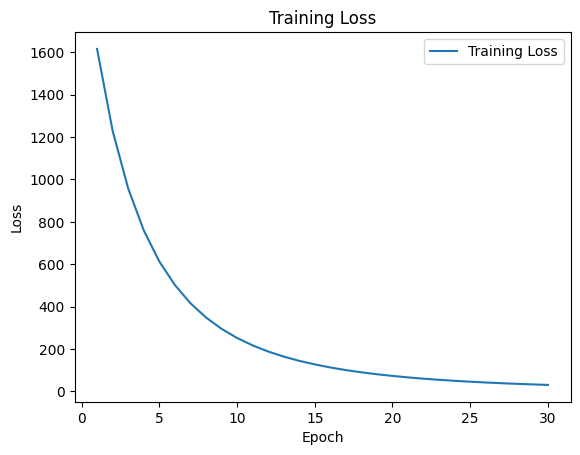

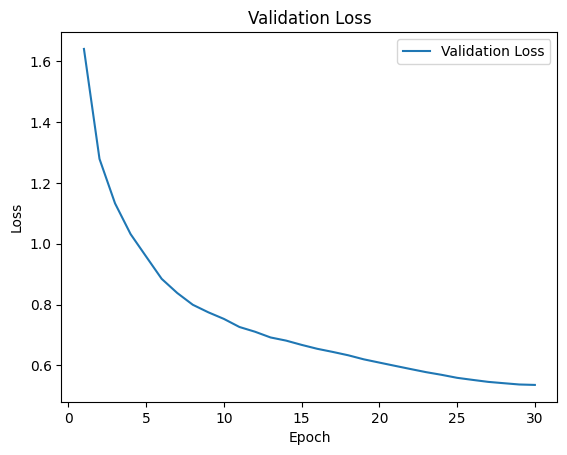

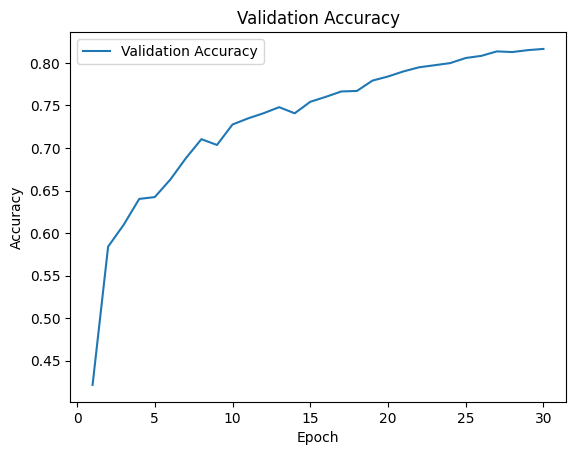

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.02, Decay Rate: 0.1, Validation Accuracy: 81.65%


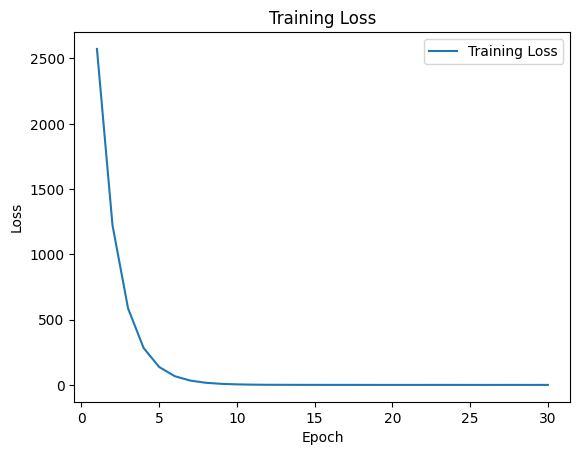

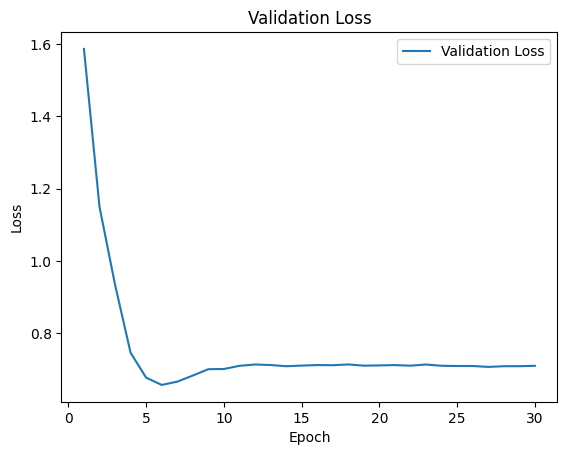

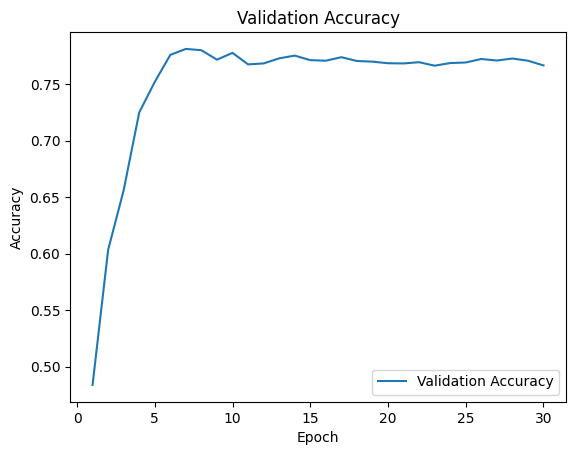

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.05, Decay Rate: 0.01, Validation Accuracy: 78.04%


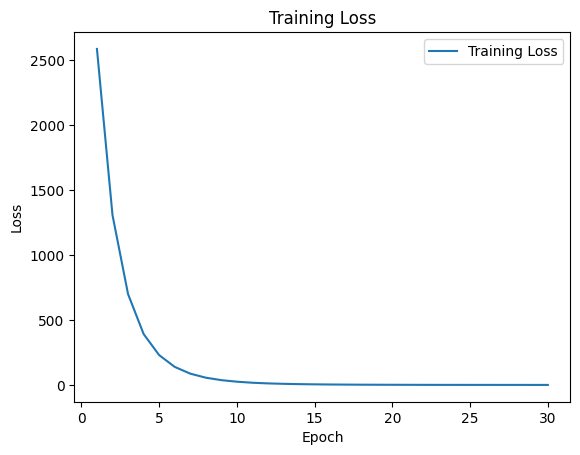

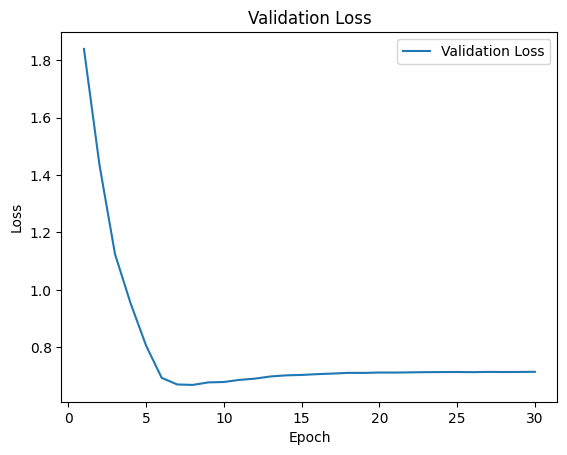

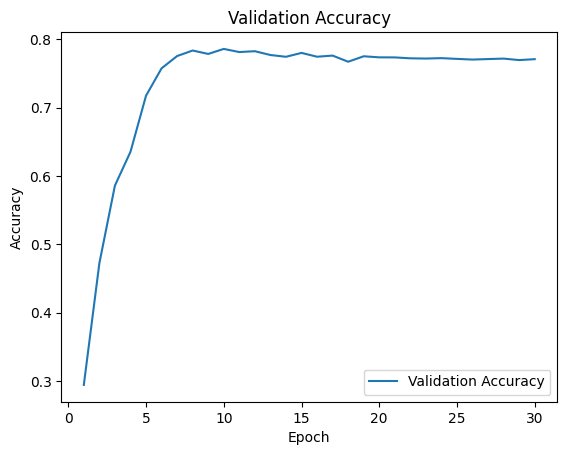

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.05, Decay Rate: 0.1, Validation Accuracy: 78.53%


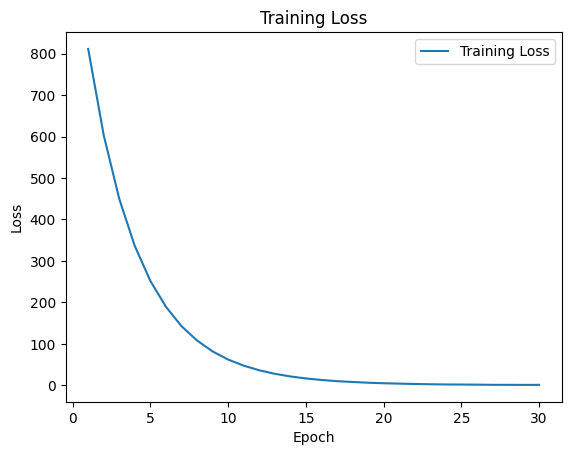

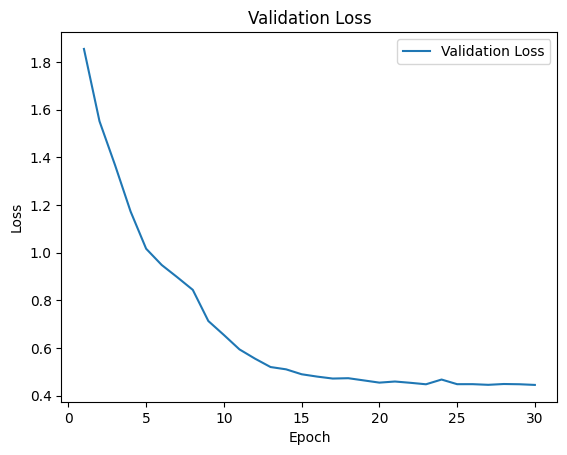

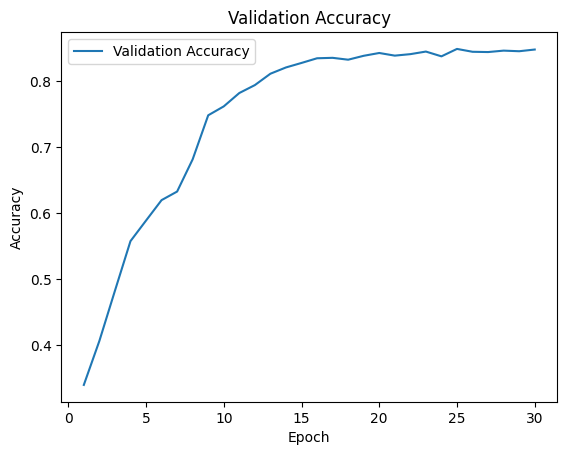

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.01, Decay Rate: 0.01, Validation Accuracy: 84.88%


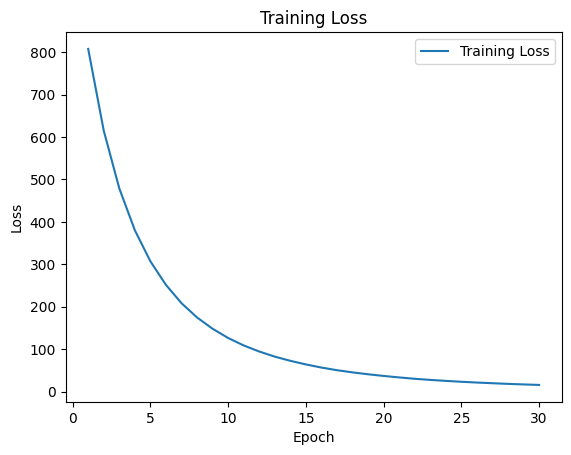

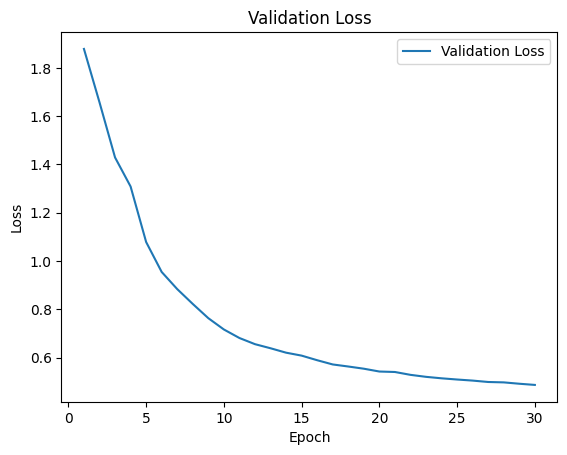

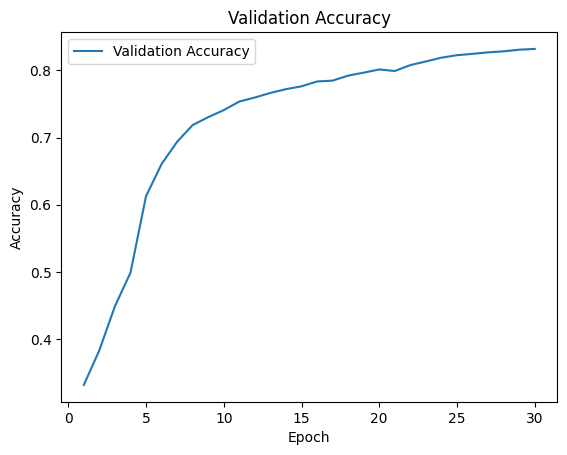

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.01, Decay Rate: 0.1, Validation Accuracy: 83.20%


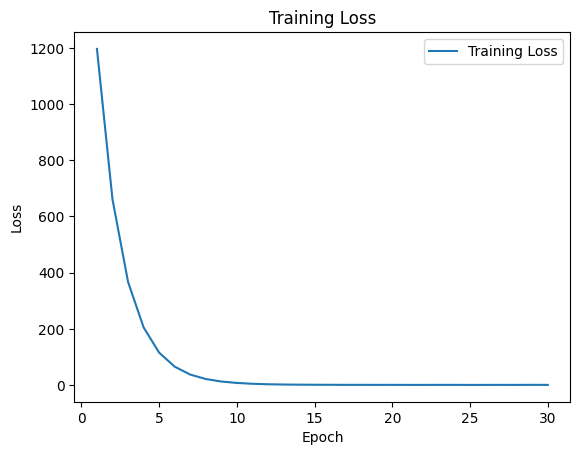

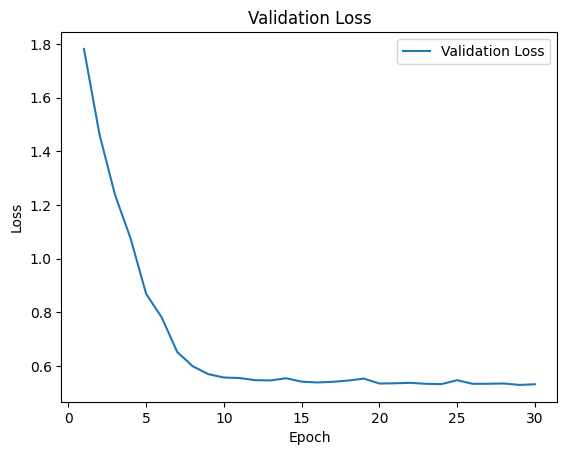

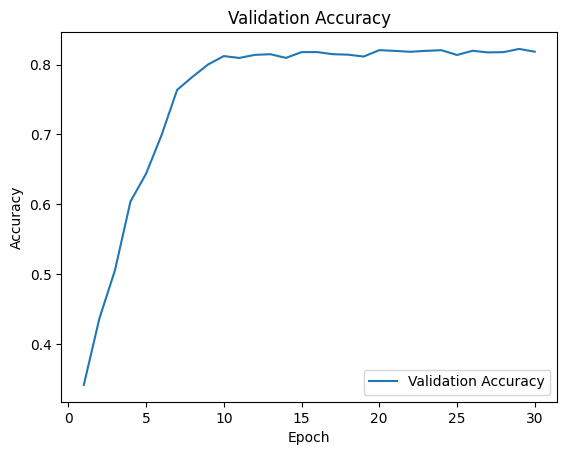

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.02, Decay Rate: 0.01, Validation Accuracy: 82.24%


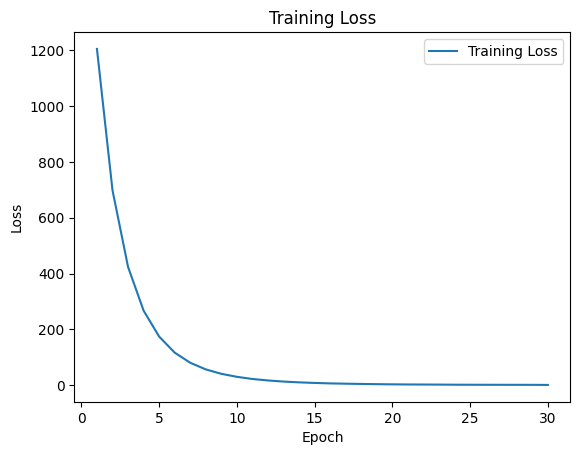

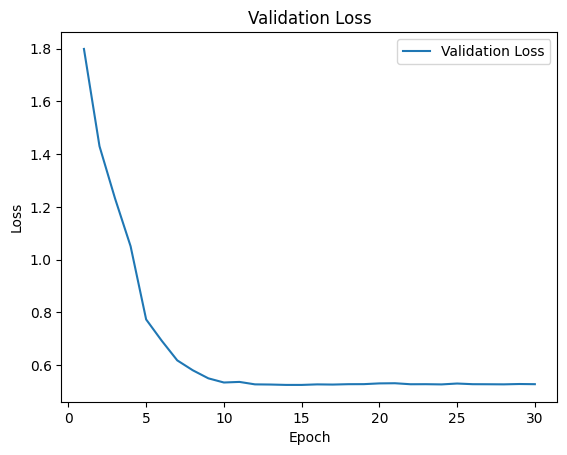

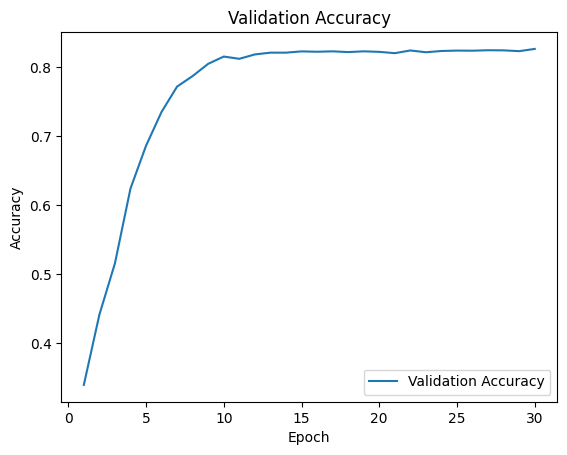

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.02, Decay Rate: 0.1, Validation Accuracy: 82.64%


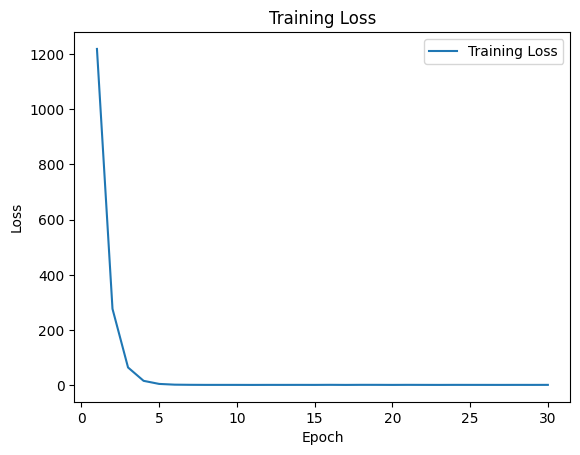

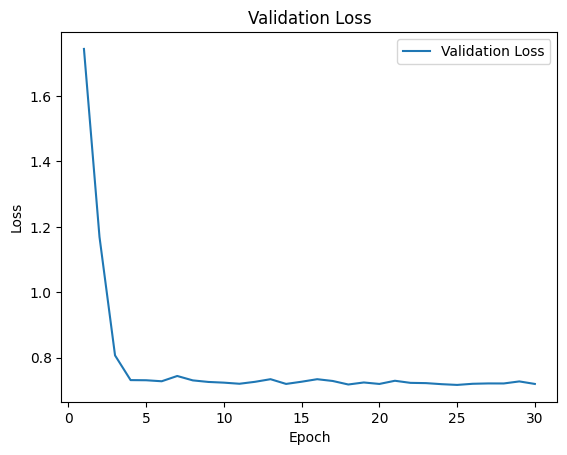

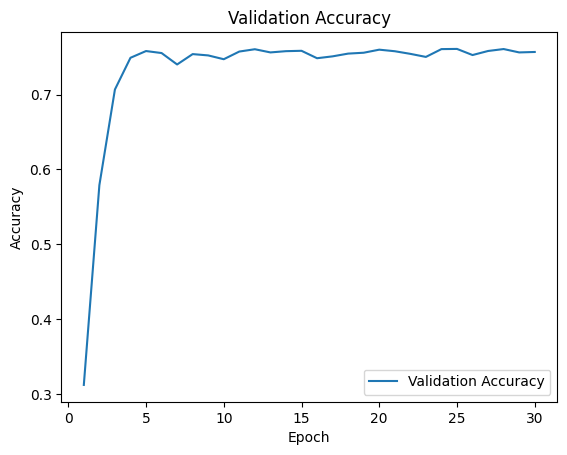

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.05, Decay Rate: 0.01, Validation Accuracy: 76.12%


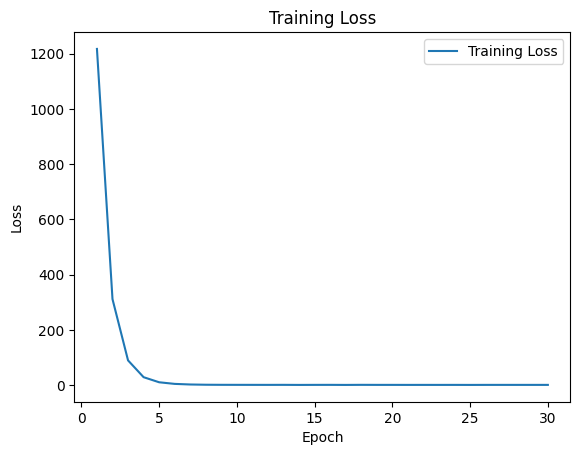

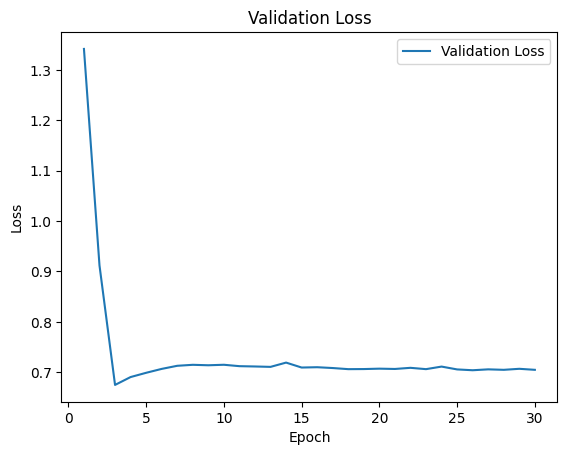

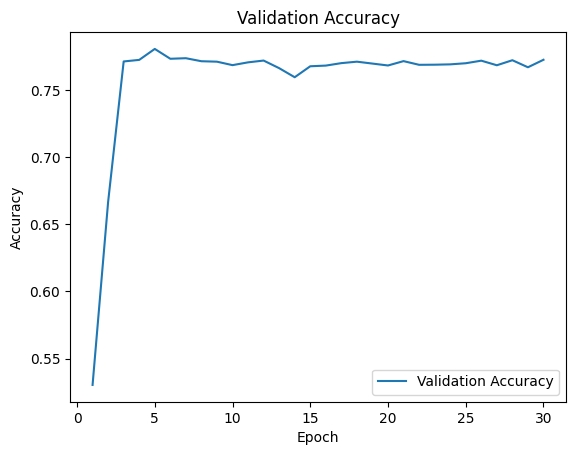

Hidden Size: [256, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.05, Decay Rate: 0.1, Validation Accuracy: 77.72%


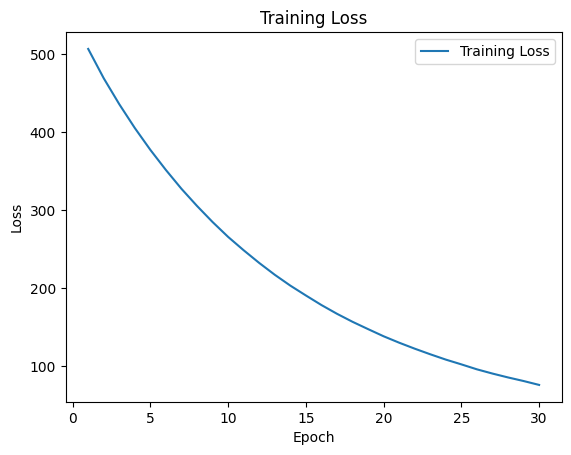

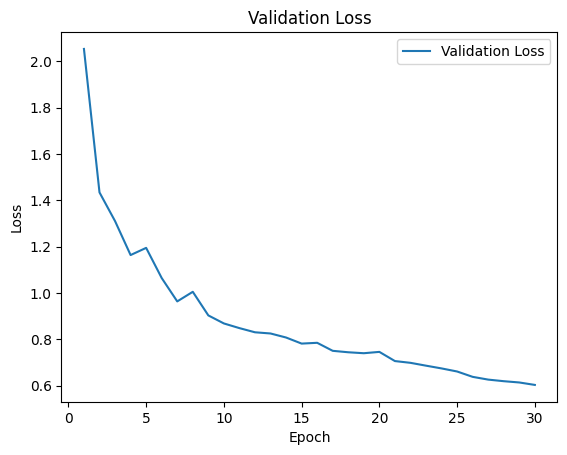

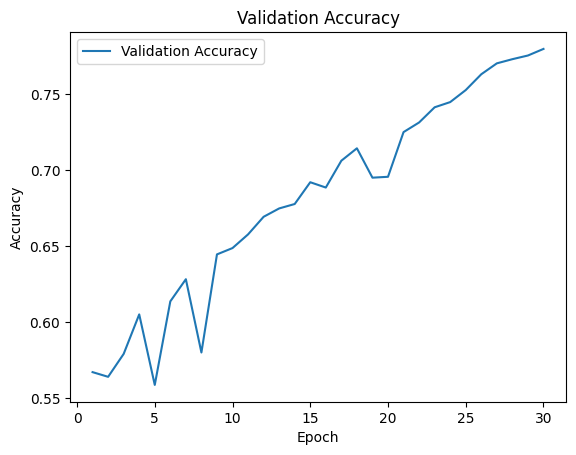

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.01, Decay Rate: 0.01, Validation Accuracy: 77.99%


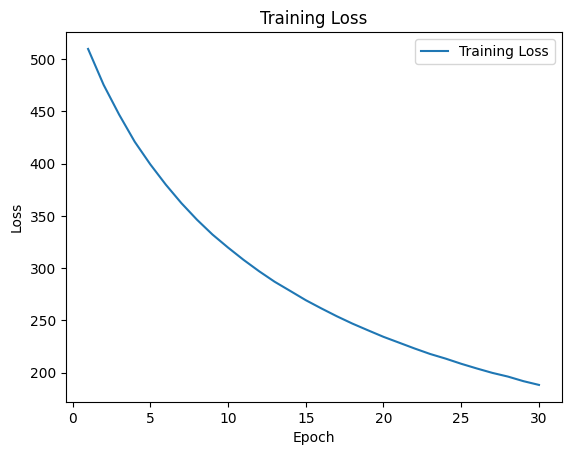

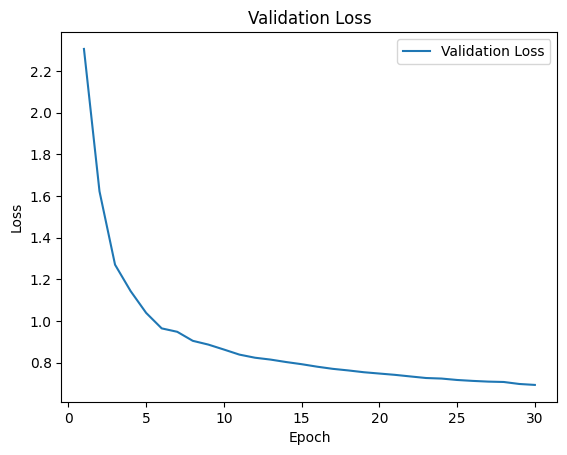

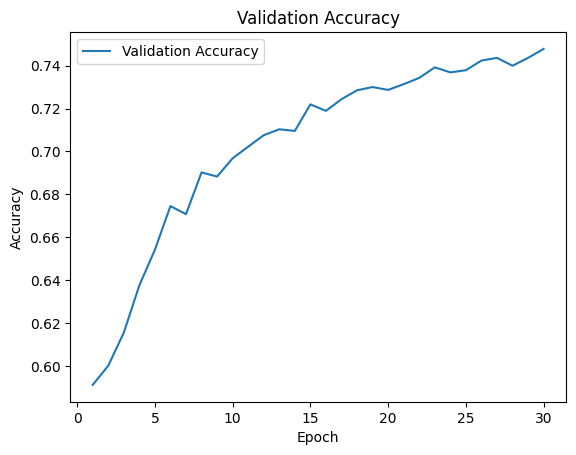

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.01, Decay Rate: 0.1, Validation Accuracy: 74.78%


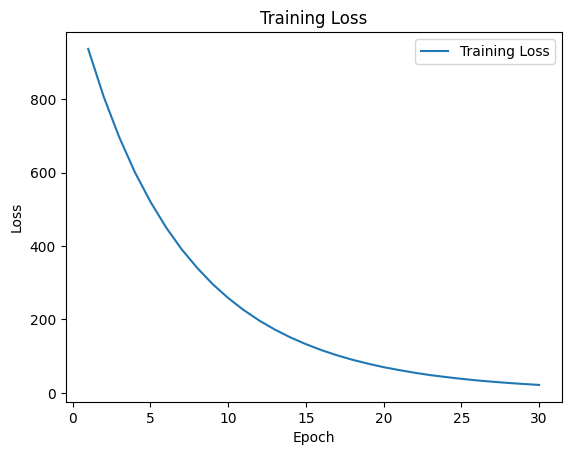

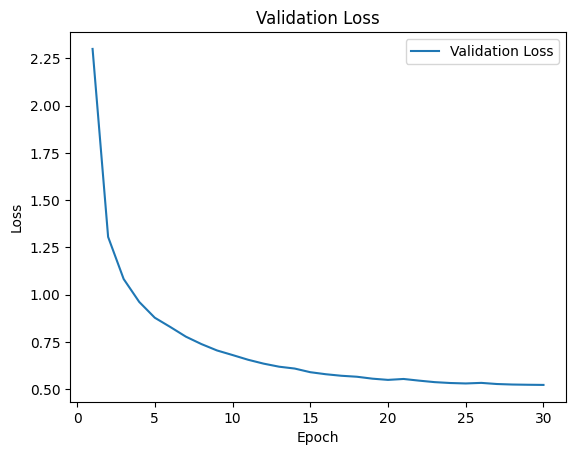

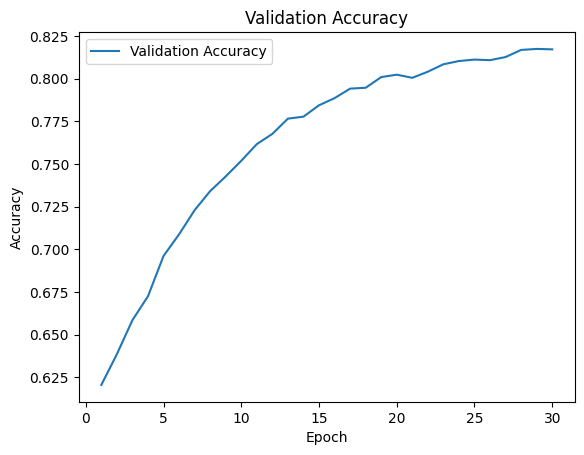

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.02, Decay Rate: 0.01, Validation Accuracy: 81.73%


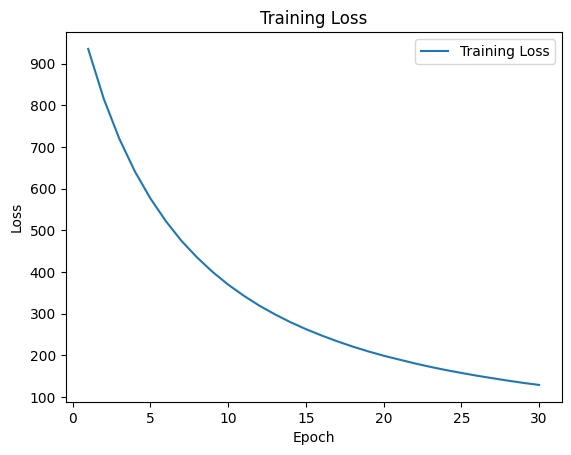

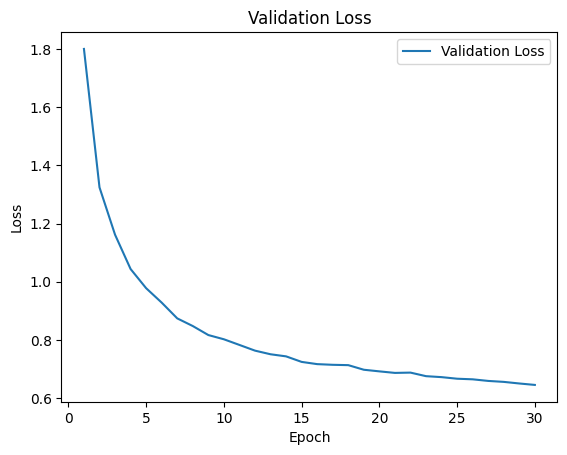

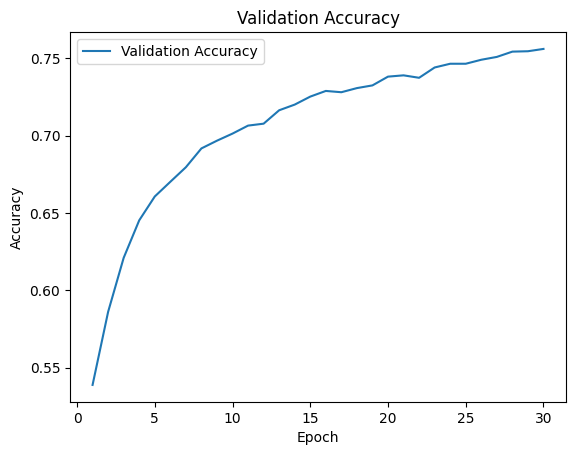

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.02, Decay Rate: 0.1, Validation Accuracy: 75.60%


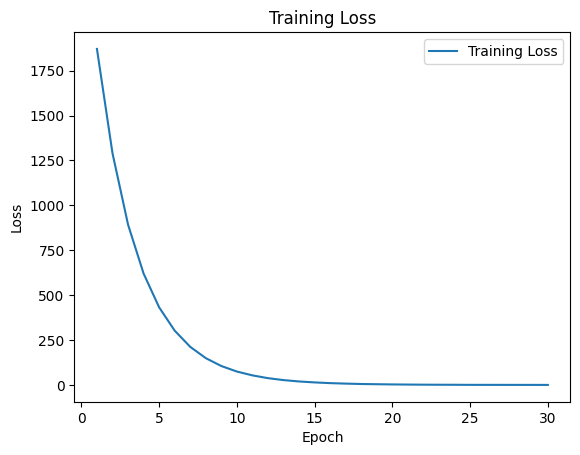

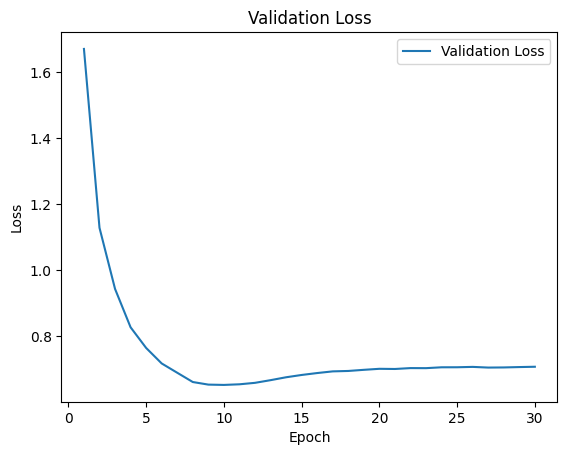

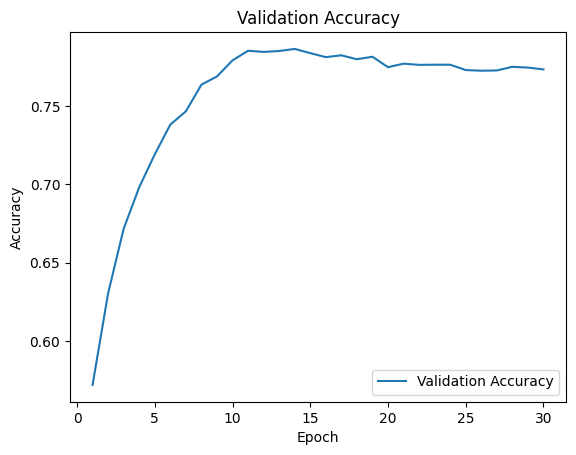

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.05, Decay Rate: 0.01, Validation Accuracy: 78.52%


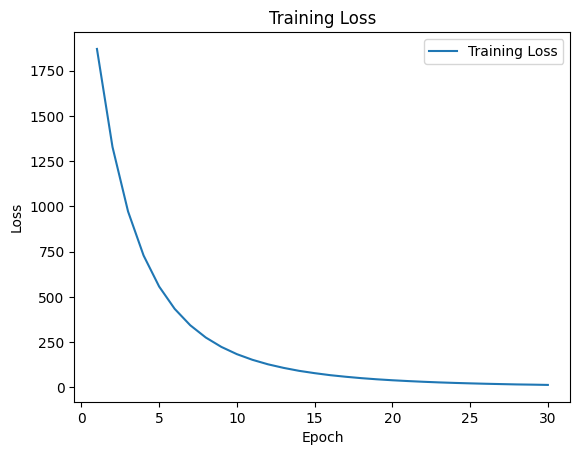

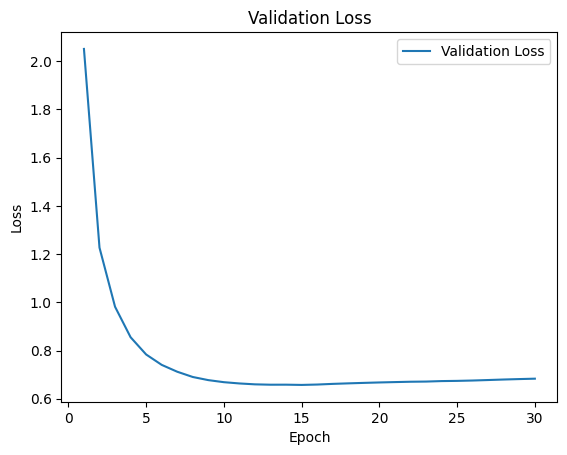

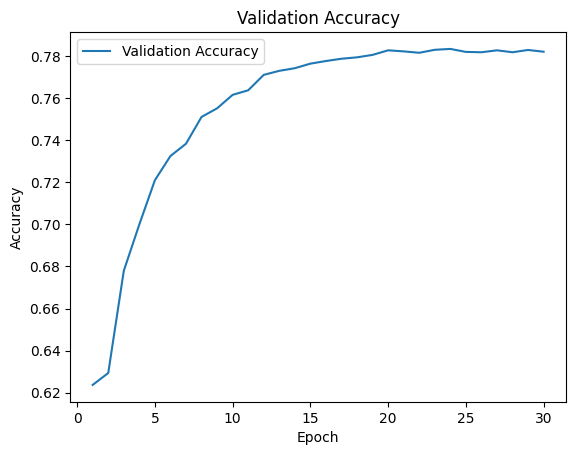

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.005, Regularization Lambda: 0.05, Decay Rate: 0.1, Validation Accuracy: 78.32%


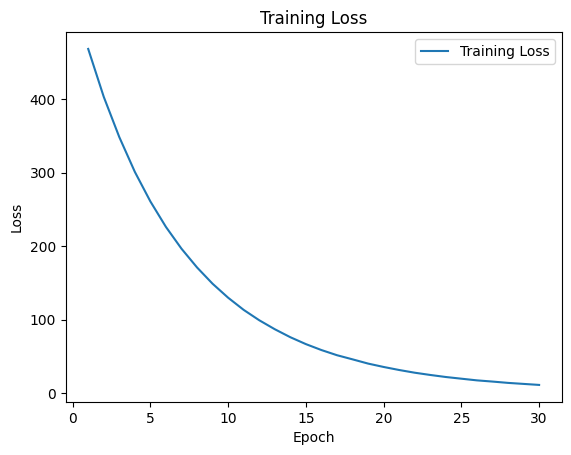

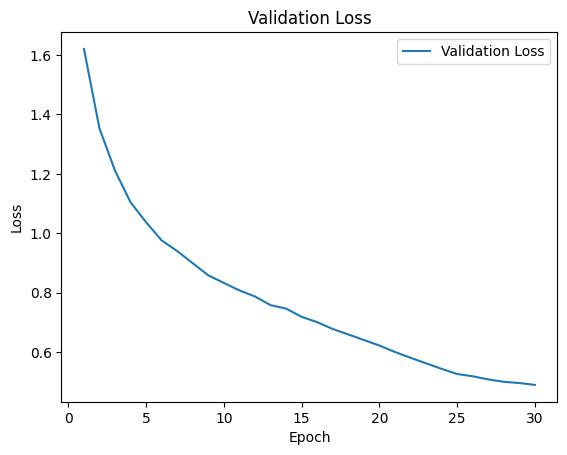

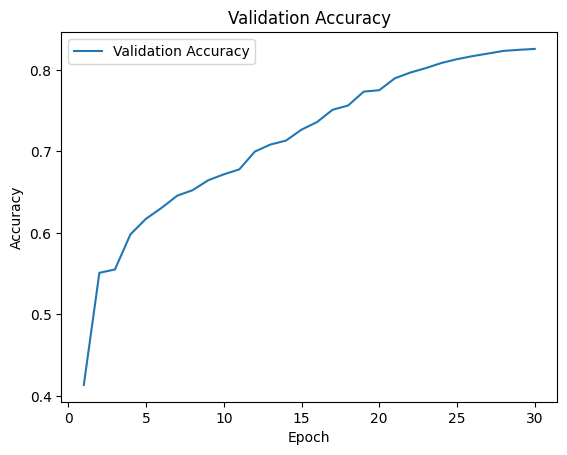

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.01, Decay Rate: 0.01, Validation Accuracy: 82.58%


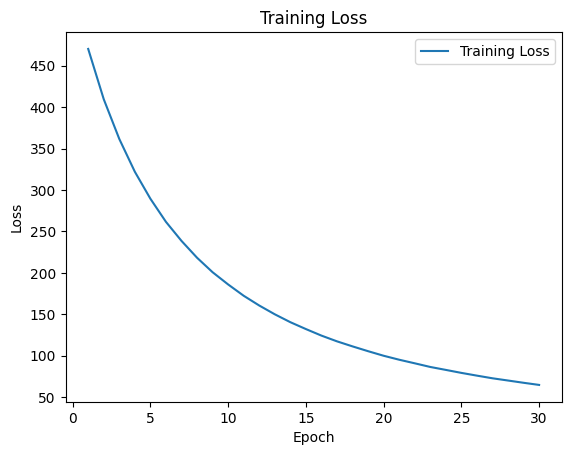

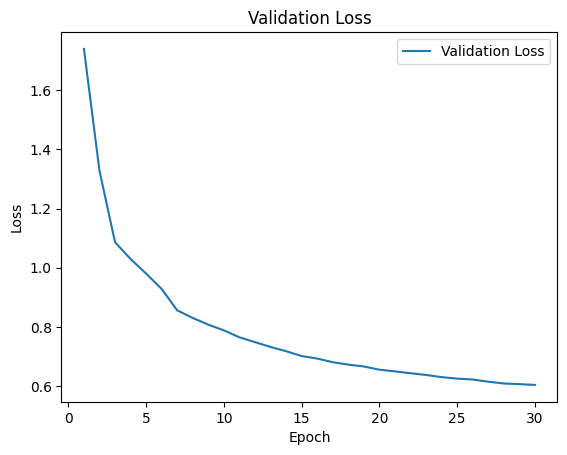

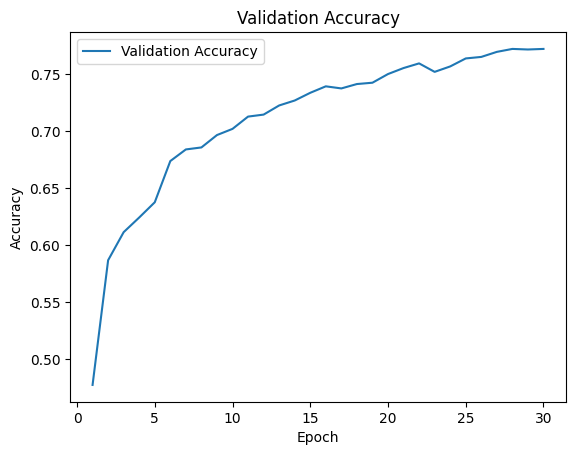

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.01, Decay Rate: 0.1, Validation Accuracy: 77.16%


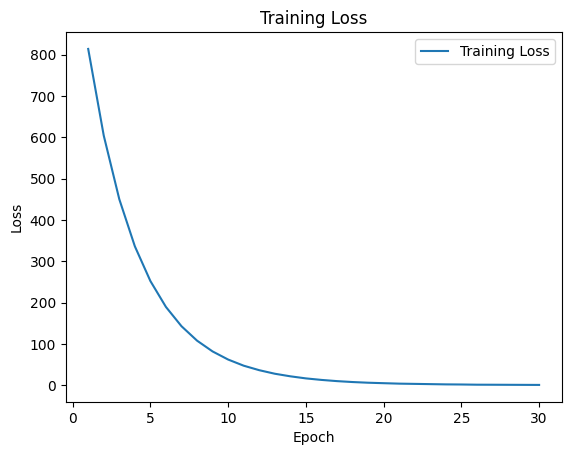

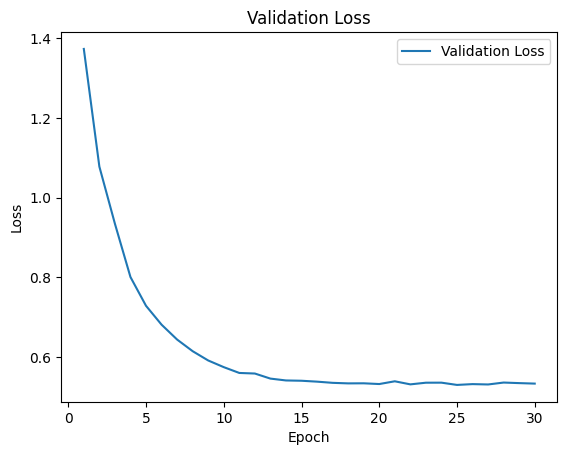

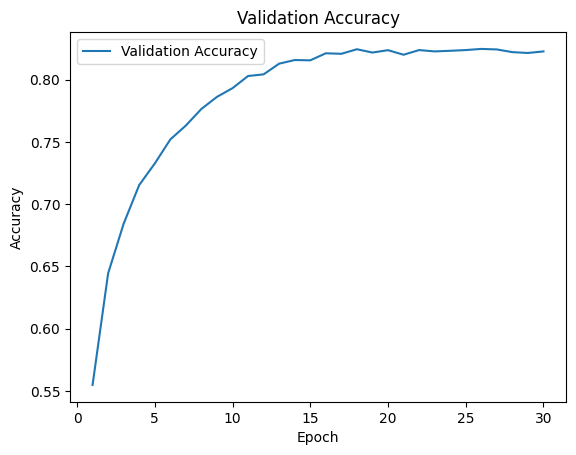

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.02, Decay Rate: 0.01, Validation Accuracy: 82.48%


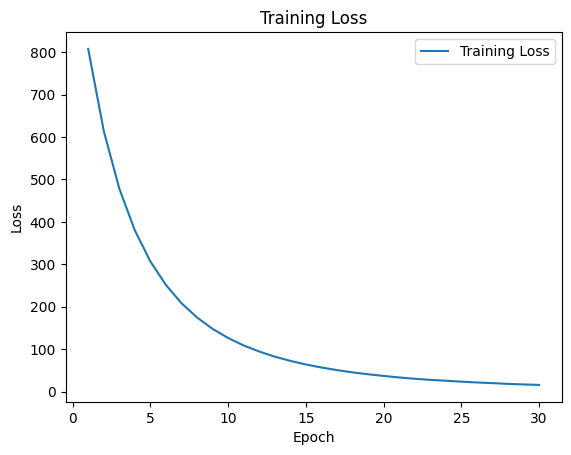

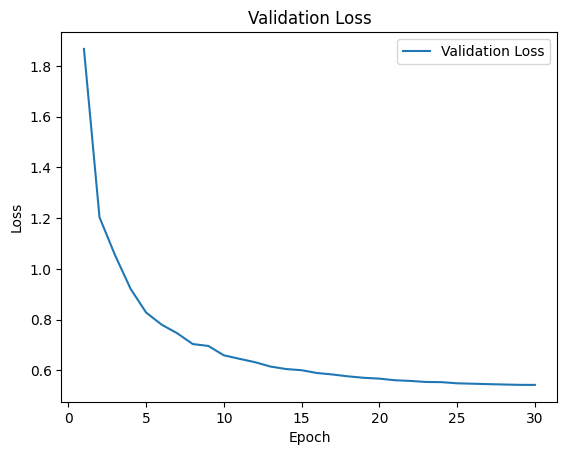

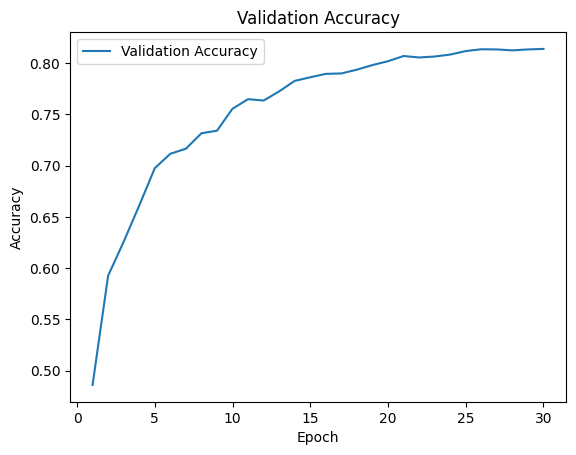

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.02, Decay Rate: 0.1, Validation Accuracy: 81.38%


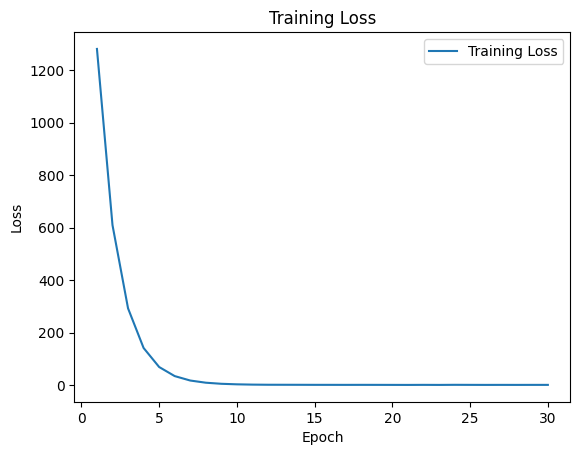

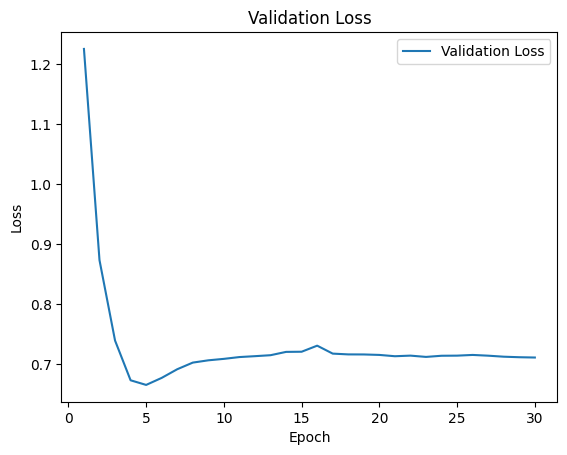

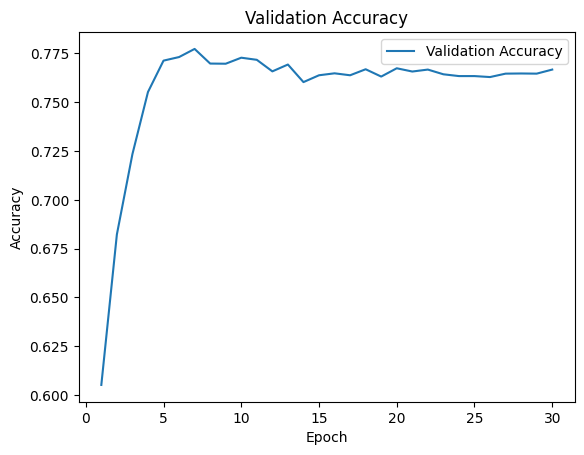

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.05, Decay Rate: 0.01, Validation Accuracy: 78.06%


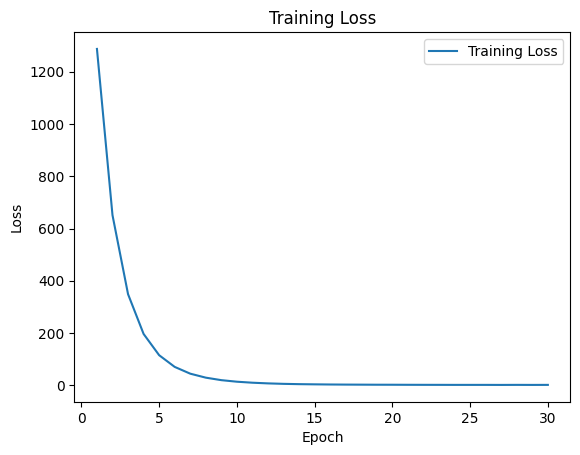

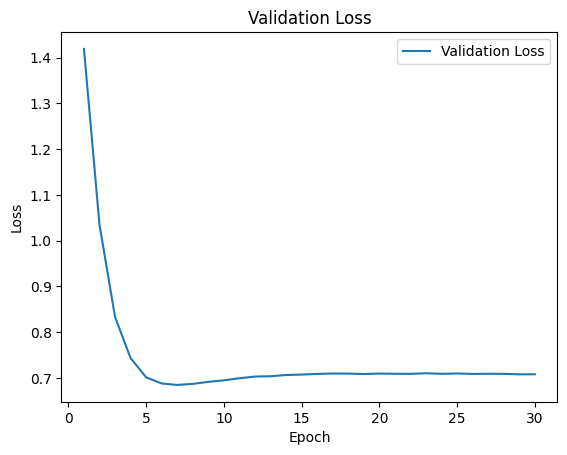

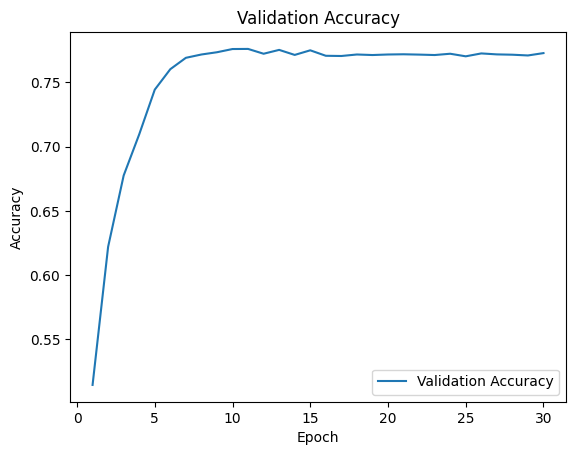

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.01, Regularization Lambda: 0.05, Decay Rate: 0.1, Validation Accuracy: 77.45%


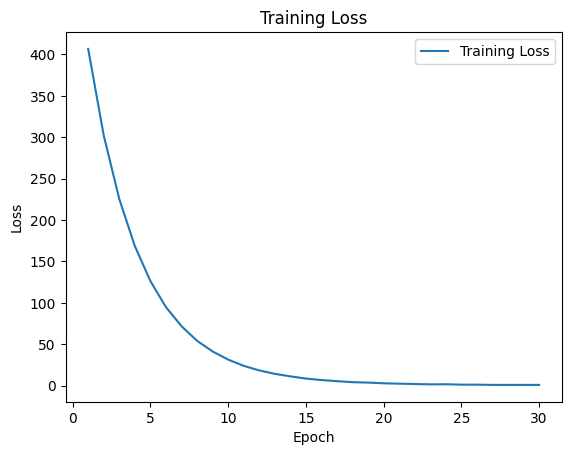

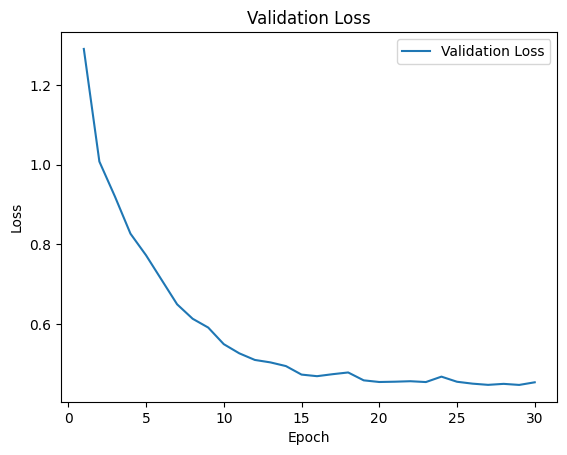

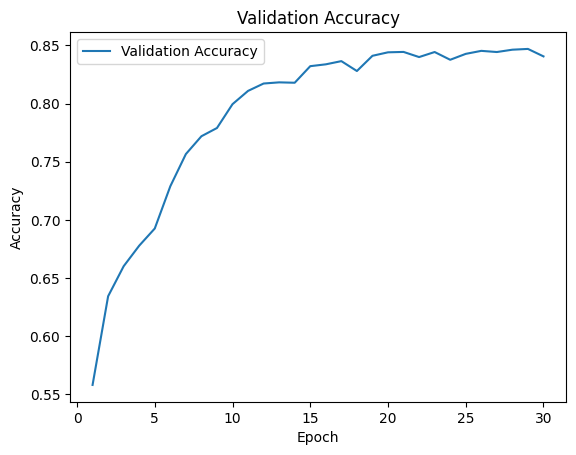

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.01, Decay Rate: 0.01, Validation Accuracy: 84.73%


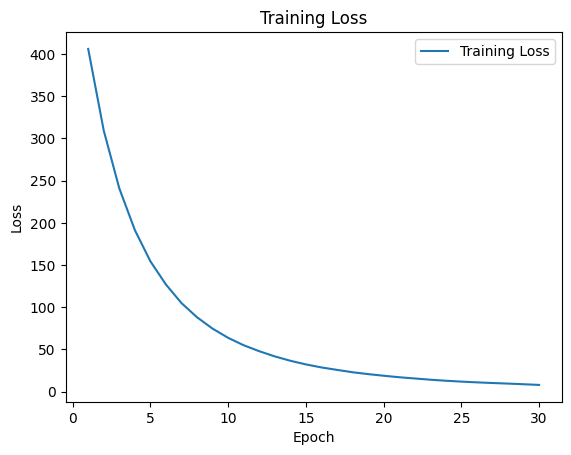

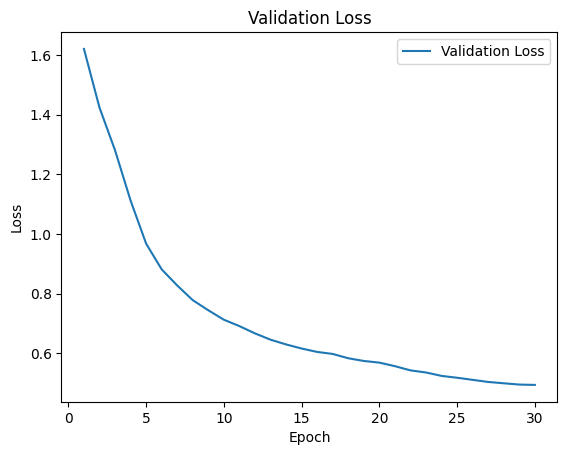

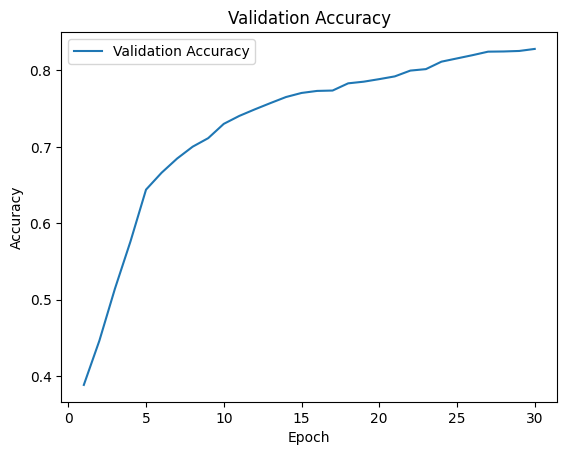

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.01, Decay Rate: 0.1, Validation Accuracy: 82.80%


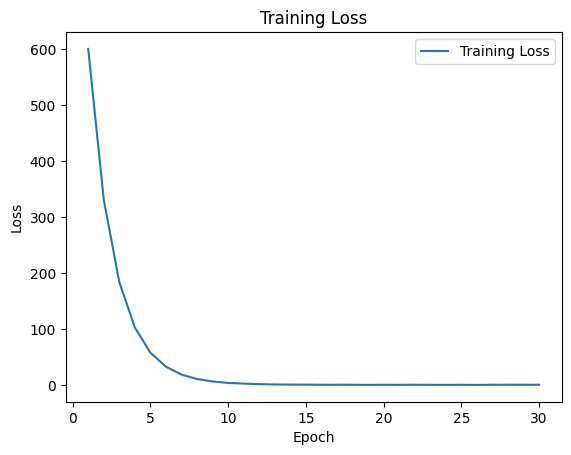

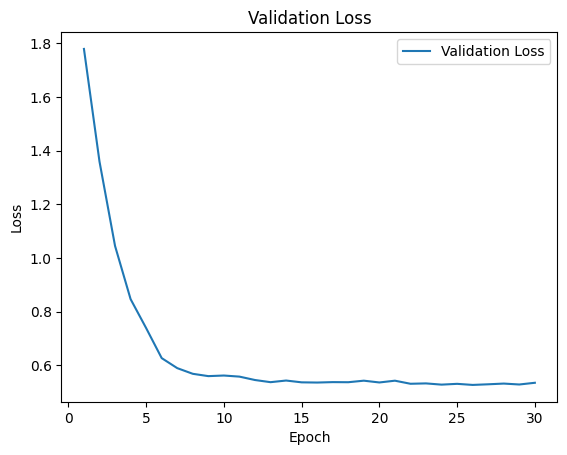

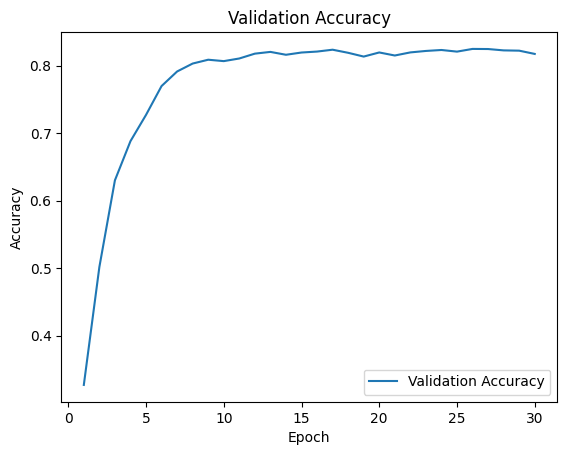

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.02, Decay Rate: 0.01, Validation Accuracy: 82.50%


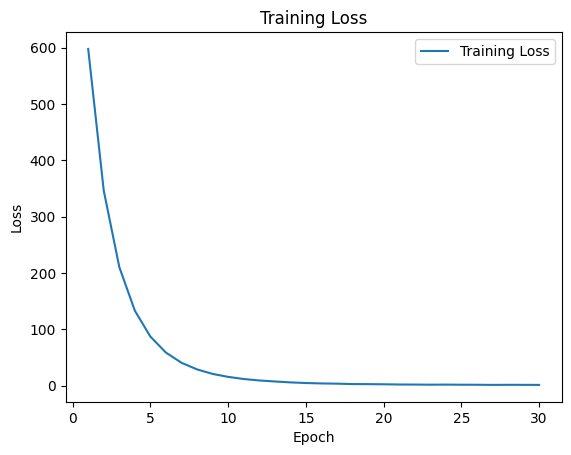

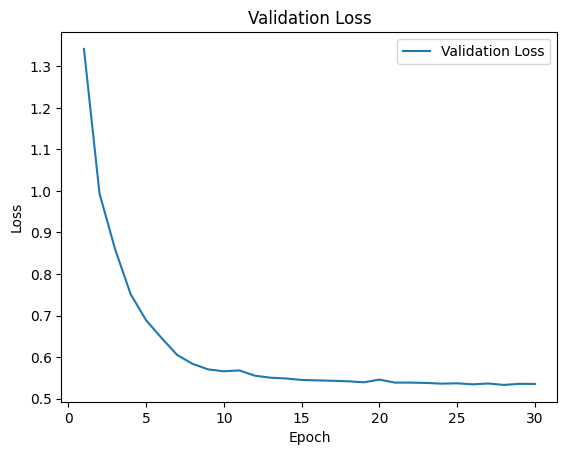

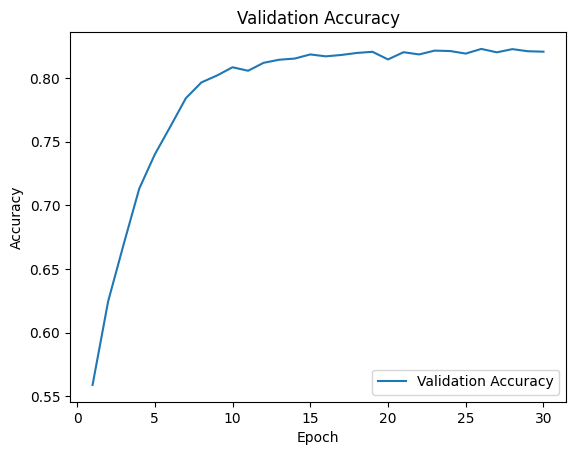

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.02, Decay Rate: 0.1, Validation Accuracy: 82.32%


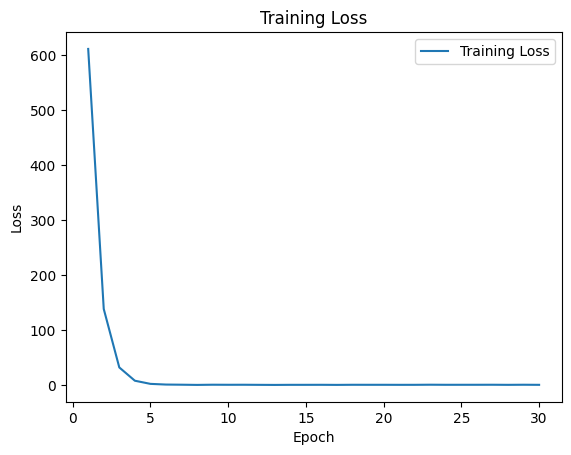

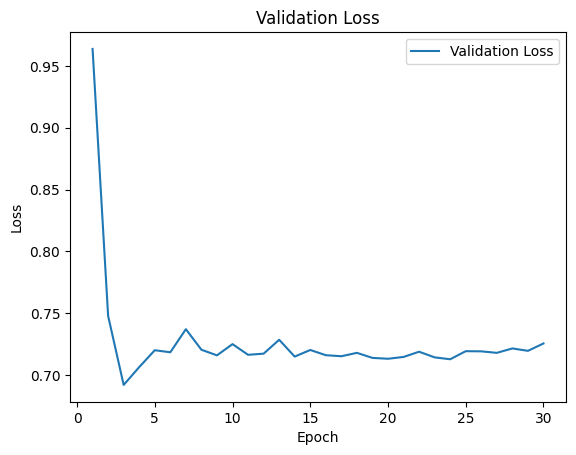

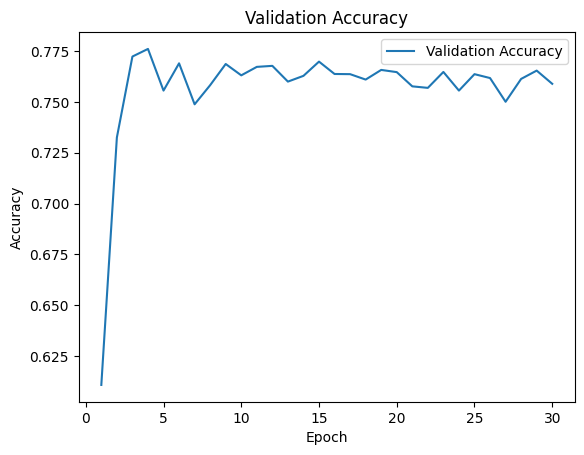

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.05, Decay Rate: 0.01, Validation Accuracy: 76.65%


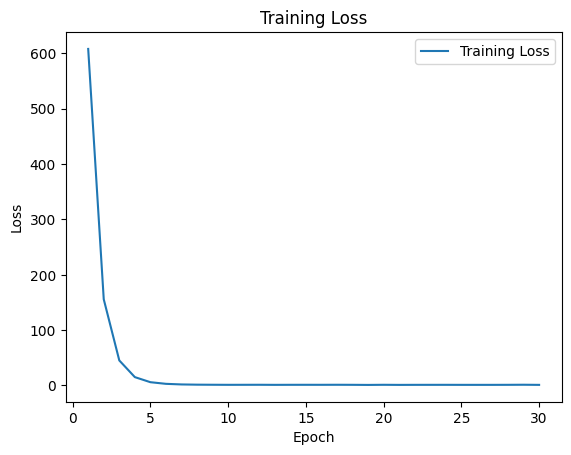

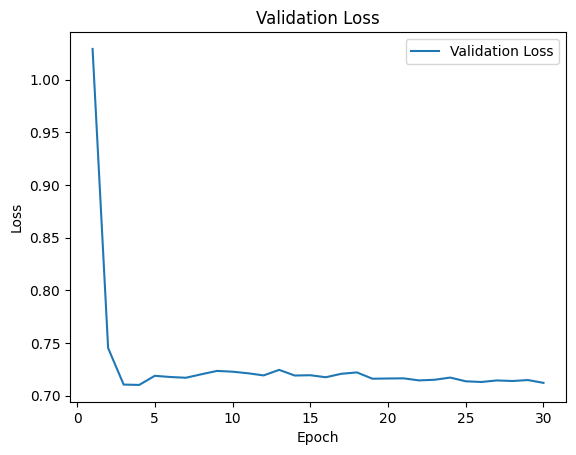

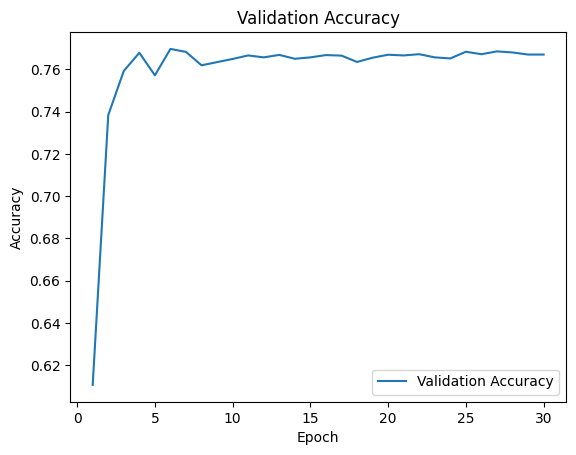

Hidden Size: [128, 64], Activation: relu, Learning Rate: 0.02, Regularization Lambda: 0.05, Decay Rate: 0.1, Validation Accuracy: 77.11%

Best Model Parameters:
Hidden Sizes: [256, 64]
Activation Function: relu
Learning Rate: 0.02
Regularization Lambda: 0.01
Best Decay Rate: 0.01


In [201]:
best_model = parameter_search(X_train, y_train, X_val, y_val, input_size=784, output_size=10, 
                              hidden_sizes=[[256, 64], [128, 64]], 
                              activation_functions=['relu'], 
                              learning_rates=[0.005, 0.01, 0.02], 
                              reg_lambda_values=[0.01, 0.02, 0.05], 
                              decay_rates=[0.01, 0.1],
                              num_epochs=30, batch_size=64)

# 测试模型（导入训练好的模型）

In [202]:
test(test_images, test_labels_one_hot, best_model)

Test Accuracy: 83.48%


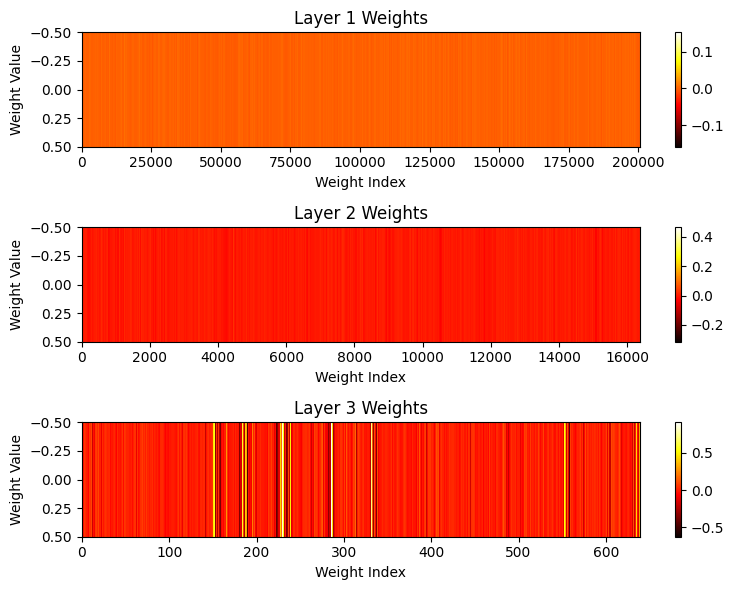

In [203]:
def visualize_weights(model):
    fig, axs = plt.subplots(nrows=len(model.weights), figsize=(8, 2 * len(model.weights)))

    for i, weights in enumerate(model.weights):
        # Reshape the weights if they are not 1D
        weights_1d = weights.flatten()

        # Plot the weights as a bar chart or heatmap
        if len(weights_1d) > 100:  # Use heatmap for large weights
            im = axs[i].imshow(weights_1d.reshape(1, -1), cmap='hot', aspect='auto')
            fig.colorbar(im, ax=axs[i], orientation='vertical')  # Add a colorbar to a plot
        else:  # Use bar chart for small weights
            axs[i].bar(range(len(weights_1d)), weights_1d)

        axs[i].set_title(f'Layer {i+1} Weights')
        axs[i].set_xlabel('Weight Index')
        axs[i].set_ylabel('Weight Value')

    plt.tight_layout()
    plt.show()

# Assuming you have defined your NeuralNetwork class with appropriate methods
visualize_weights(best_model)

In [213]:
np.save('best_model.npy', best_model)